## Kubernetes allocation dynamique d'executeur

Dans le tutorial précédent nous avons que le driver spark lance un nombre fixe d'executeur pour répondre à tous les jobs spark.
L'objectif est maintenant de rendre ceci dynamique.

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import os

conf = SparkConf()
#url par défaut d'une api kubernetes accédé depuis l'intérieur du cluster (ici le notebook tourne lui même dans kubernetes)
conf.setMaster("k8s://https://kubernetes.default.svc:443")
#image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
conf.set("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master")
# Nom du namespace kubernetes
conf.set("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
# Mémoire alloué à la JVM
# Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
# On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
conf.set("spark.executor.memory", "4g")
conf.set("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])

#configuration de la dynamicAllocation
conf.set("spark.dynamicAllocation.enabled","true")
conf.set("spark.dynamicAllocation.initialExecutors","1")
conf.set("spark.dynamicAllocation.minExecutors","1")
conf.set("spark.dynamicAllocation.maxExecutors","60")
#Le ratio corresponds aux nombres de pods à créer pour une nombre de taches parallèles 
#(100 taches parrallèles, ratio 1, on vise 100 pods, avec 0.5 ce serait 50 pods)
conf.set("spark.dynamicAllocation.executorAllocationRatio","1")
conf.set("spark.dynamicAllocation.shuffleTracking.enabled","true")


sc = SparkContext(conf=conf)



Le contexte spark se lance et si l'on utilise un terminal pour afficher l'ensemble des pods qui sont dans notre namespace, on voit que spark à lancer un seul executeur dans le cluster kubernetes. Plutôt stylé !

On peut le vérifier facilement avec kubectl car le template spark pour un pod comporte le label spark-role=executor

In [34]:
! kubectl get pods -l spark-role=executor

NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-39a86278cc89f4fc-exec-3   1/1     Running   0          38m


ou sur l'ihm spark onglet executor

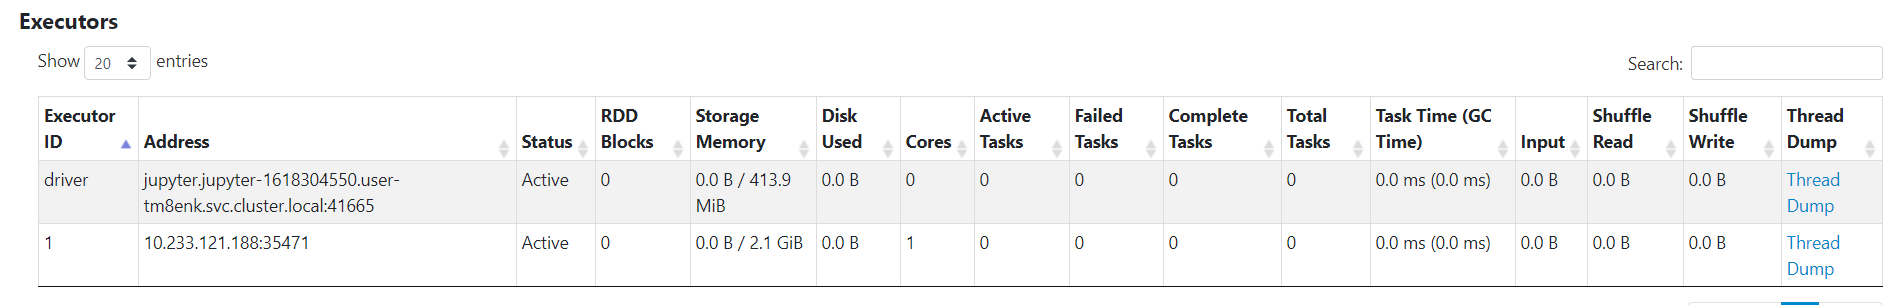

#### Les données : sirene opendata

On va réutiliser exactement les codes du tutorial précédant avec une allocation statique du nombre d'executeur.

In [2]:
import json
from pyspark.sql.types import StructType
import s3fs
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

with fs.open('s3://projet-spark-lab/diffusion/formation/schema/sirene/sirene.schema.json') as f:
  a = f.read()
  schema = StructType.fromJson(json.loads(a))
    
from pyspark import SQLContext
sqlContext=SQLContext(sc)
df = sqlContext.read.format("csv").options(header='true', inferschema='false', delimiter=',').schema(schema).load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")

df.createOrReplaceTempView("sirene")
sqlDF = sqlContext.sql("SELECT * FROM sirene")
sqlDF.first()

Row(siren=325175, nic=16, siret=32517500016, dateFin='2007-12-31', dateDebut='2000-09-26', etatAdministratifEtablissement='A', changementEtatAdministratifEtablissement=False, enseigne1Etablissement=None, enseigne2Etablissement=None, enseigne3Etablissement=None, changementEnseigneEtablissement=False, denominationUsuelleEtablissement=None, changementDenominationUsuelleEtablissement=False, activitePrincipaleEtablissement=None, nomenclatureActivitePrincipaleEtablissement=None, changementActivitePrincipaleEtablissement='false', caractereEmployeurEtablissement='N', changementCaractereEmployeurEtablissement='false')

In [4]:
! kubectl get pods -l spark-role=executor

NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-b2616978ccea1c47-exec-1   1/1     Running   0          2m45s


La requête first nécessite aucun parallélisme puisqu'on ne lit qu'une seule partition de donnée pour être en mesure de répondre.

### Augmentons le nombre de taches

Pour cela nous allons forcer la lecture de tout le csv. Cela se fera en fonction du nombre de partition du dataframe original. En effet spark dans sa configuration par défaut travaille sur 128 Mo de données et va donc découper le job sur les 6,5 Go en 53 taches 




In [5]:
%%timeit -r3
sqlDF.count()

12.8 s ± 3.82 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [6]:
! kubectl get pods -l spark-role=executor

NAME                                     READY   STATUS    RESTARTS   AGE
pyspark-shell-b2616978ccea1c47-exec-1    1/1     Running   0          17m
pyspark-shell-b2616978ccea1c47-exec-10   1/1     Running   0          4m6s
pyspark-shell-b2616978ccea1c47-exec-11   1/1     Running   0          4m6s
pyspark-shell-b2616978ccea1c47-exec-12   1/1     Running   0          4m6s
pyspark-shell-b2616978ccea1c47-exec-13   1/1     Running   0          4m6s
pyspark-shell-b2616978ccea1c47-exec-14   1/1     Running   0          4m5s
pyspark-shell-b2616978ccea1c47-exec-15   1/1     Running   0          4m5s
pyspark-shell-b2616978ccea1c47-exec-16   1/1     Running   0          4m5s
pyspark-shell-b2616978ccea1c47-exec-17   1/1     Running   0          4m5s
pyspark-shell-b2616978ccea1c47-exec-18   1/1     Running   0          4m5s
pyspark-shell-b2616978ccea1c47-exec-19   1/1     Running   0          4m4s
pyspark-shell-b2616978ccea1c47-exec-2    1/1     Running   0          4m10s
pyspark-shell-b2616978ccea

Vous pouvez constater qu'on a bien lancé 53 executeurs dynamiquements
Si vous attendez suffisamment longtemps sans envoyer de job à spark, les executeurs vont progressivement s'éteindre.

In [7]:
! kubectl get pods -l spark-role=executor

NAME                                     READY   STATUS    RESTARTS   AGE
pyspark-shell-b2616978ccea1c47-exec-13   1/1     Running   0          10m


### Que se passe t'il pour le cache ?

La question qui vient dès lors qu'on fait de l'allocation dynamique c'est de voir comment fonctionne le cache des dataframe.
Va t'il empecher la fermeture des pods qui contiennent des partitions en cache ? 


In [8]:
sqlDF.cache()

DataFrame[siren: int, nic: int, siret: bigint, dateFin: string, dateDebut: string, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

In [9]:
%%timeit -r3
sqlDF.count()

791 ms ± 136 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


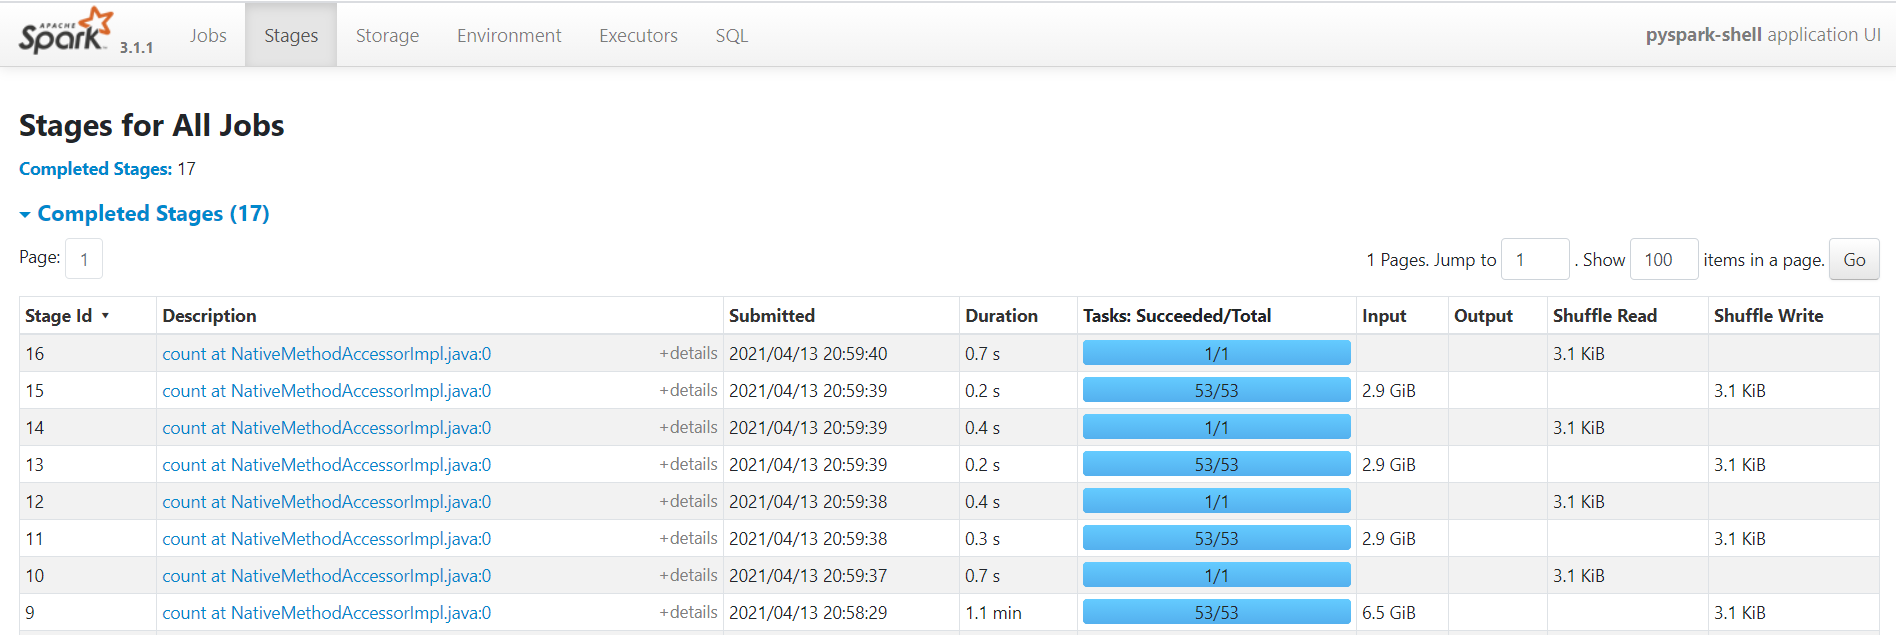

Et vous pouvez vérifier sur votre spark UI mais le premier job a été très long, puisque spark avait du travail supplémentaire pour mettre en cache les données (en particulier il doit changer le format des données puisque vous voyez qu'on passe d'un csv de plus de 6go à 2,9go) mais ensuite tous les jobs suivant se sont executé à partir de la donnée en cache sans jamais revenir à la consultation du fichier sur S3. L'onglet storage vous donne de l'information sur les rdd en cache, le nombre de partitions et si il a pu mettre les données en mémoire ou sur le disque des executeurs.

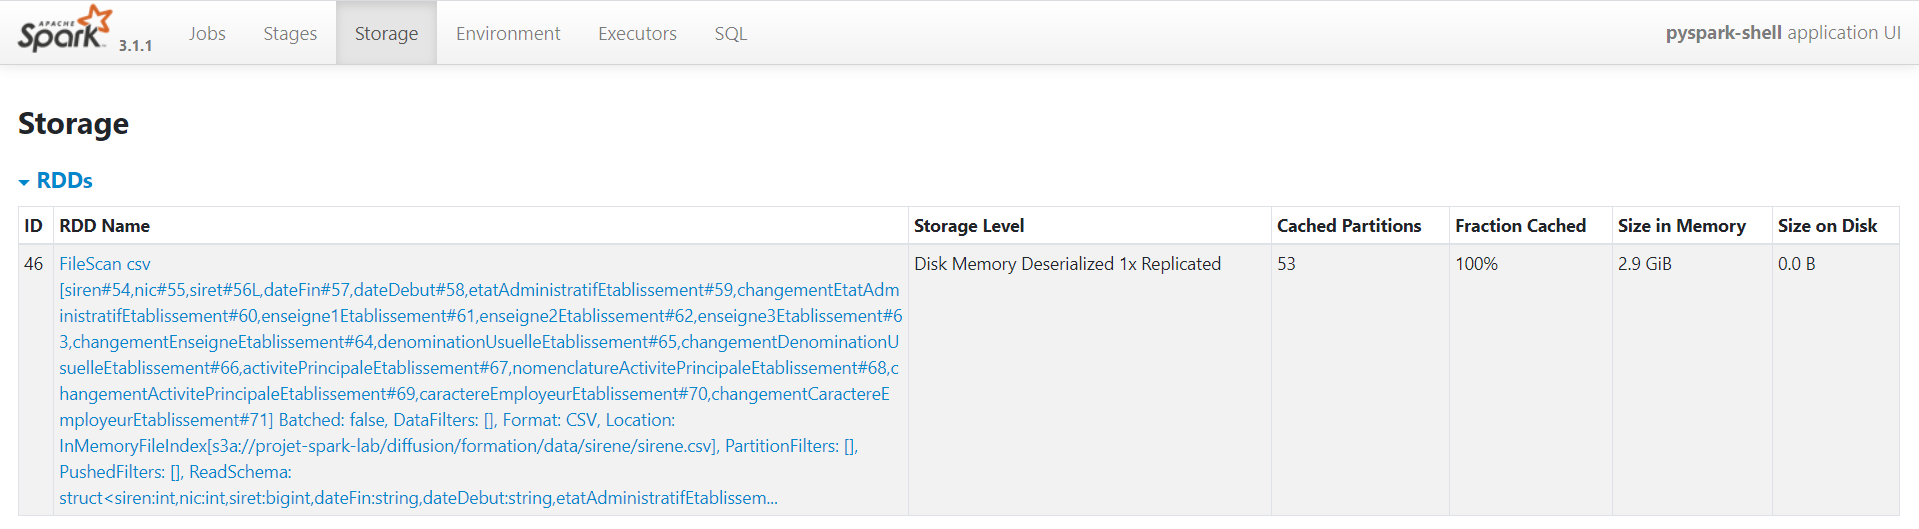

In [15]:
! kubectl get pods -l spark-role=executor

NAME                                      READY   STATUS    RESTARTS   AGE
pyspark-shell-b2616978ccea1c47-exec-100   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-101   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-102   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-103   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-104   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-105   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-106   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-107   1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-13    1/1     Running   0          50m
pyspark-shell-b2616978ccea1c47-exec-54    1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-55    1/1     Running   0          32m
pyspark-shell-b2616978ccea1c47-exec-56    1/1     Running   0          32m
pyspark-shell-b2616978cce

**Le nombre d'executor ne décroit pas. Il semblerait que spark ne veuille pas perdre de partition.**

Je vais donc supprimer ce dataframe du cache mémoire

In [17]:
sqlDF.unpersist()

DataFrame[siren: int, nic: int, siret: bigint, dateFin: string, dateDebut: string, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

On vérifie sur l'ui que le dataframe n'est plus stocké en mémoire

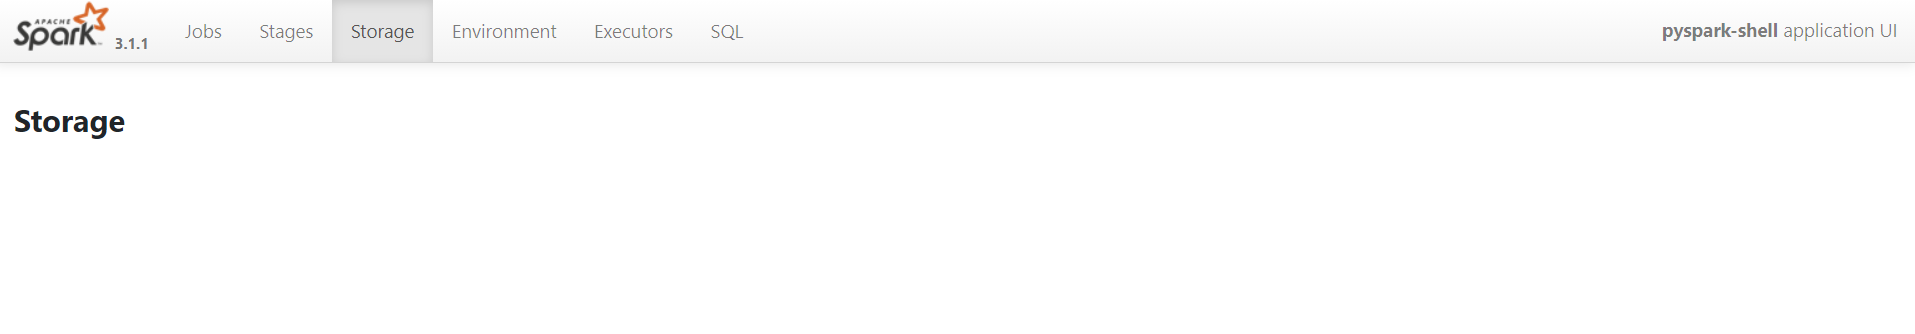

In [18]:
! kubectl get pods -l spark-role=executor

NAME                                      READY   STATUS    RESTARTS   AGE
pyspark-shell-b2616978ccea1c47-exec-102   1/1     Running   0          38m


Et assez rapidement mes executeurs sont libérés.

### Conclusion

L'allocation dynamique permet de reserver des ressources uniquement quand vous en avez besoin.
Vous avez les deux parametres suivants pour gerer l'extinction des pods qui confirme ce que nous avons pu observer dans le tutorial.

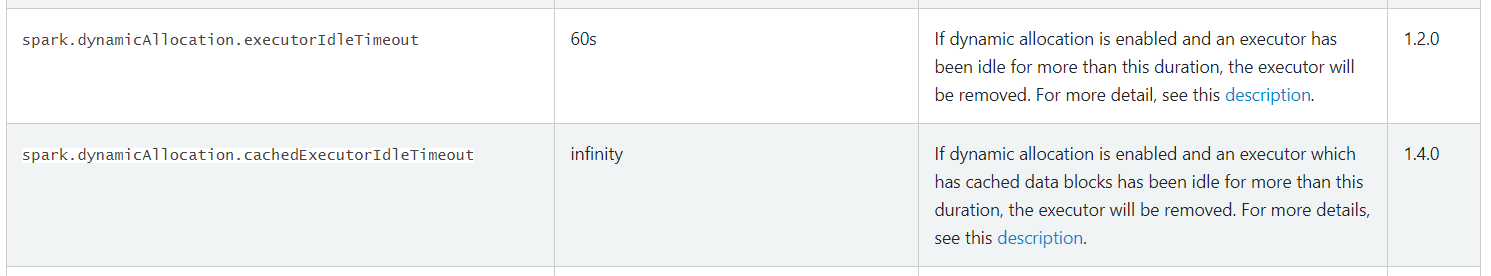

In [20]:
sc.stop()